# Building a Python Model of the ULP Feature Extractor IC

The goal is to build a python model of the feature extractor IC so that it can be used to test and train a full ML collision system feature the feature extraction IC and a detection algorithmn on FPGA/uC 

## Transconductance and Full Wave Rectifier 

The transconductance (gm) block and the full wave rectifier block (FWR) transform the bandpassed signals from the voltage domain to the current domain for simple integration. To capture the energy in the band after the gm block converts it into a current it is then rectified attempting to apply the mathmatical function of absolute value in the analog domain

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

plt.style.use('./new_plot_style.mplstyle')

img_path = './img/gm_fw/'
data_path = './data/'

### Ploting the Simulated Data
First lets import the data from the chip spice simulation to see what current comes out of a input voltage differential. Ideally, the FWR is just doing the mathmatical operation of absolute value so we can plot the abs of GM to see if any differences arises there.

In [5]:
gm_fw_import = pd.read_csv('./data/gm_FW_large.csv')

col = gm_fw_import.columns

df_gm_fw = gm_fw_import.rename(columns={col[0]: "Voltage", col[1]: "Gm", col[2]: "Voltage1", col[3]: "FWR"})
df_gm_fw.head()

,Voltage,Gm,Voltage1,FWR
0,-0.5000,-3.041169e-08,-0.5000,3.404726e-08
1,-0.4995,-3.041137e-08,-0.4995,3.404691e-08
2,-0.4990,-3.041105e-08,-0.4990,3.404655e-08
3,-0.4985,-3.041073e-08,-0.4985,3.404620e-08
4,-0.4980,-3.041040e-08,-0.4980,3.404584e-08


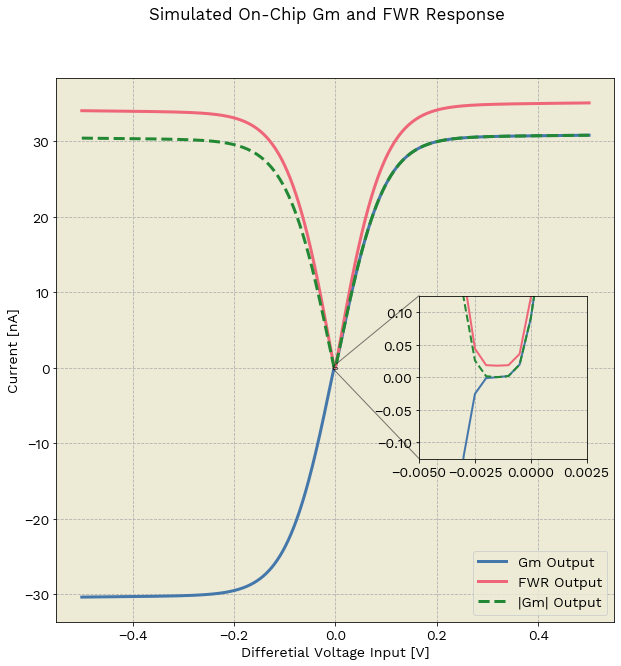

In [54]:
fig,ax = plt.subplots(1,figsize=[10,10], sharex=True)
fig.suptitle("Simulated On-Chip Gm and FWR Response")
ax.plot(df_gm_fw["Voltage"], df_gm_fw["Gm"]*1e9, label="Gm Output")
ax.set_ylabel("Current [nA]")
ax.legend()

ax.plot(df_gm_fw["Voltage"], df_gm_fw["FWR"]*1e9, label="FWR Output")
ax.set_ylabel("Current [nA]")
ax.set_xlabel("Differetial Voltage Input [V]")


ax.plot(df_gm_fw["Voltage"], np.abs(df_gm_fw["Gm"]*1e9), label="|Gm| Output",linestyle="dashed")
ax.legend()
axins = ax.inset_axes([0.65, 0.3, 0.3, 0.3])


x1, x2, y1, y2 = -0.005, 0.0025, -.125, .125
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels('')
#axins.set_yticklabels('')
axins.plot(df_gm_fw["Voltage"], df_gm_fw["Gm"]*1e9, label="Gm Output", linewidth=2)
axins.plot(df_gm_fw["Voltage"], df_gm_fw["FWR"]*1e9, label="FWR Output", linewidth=2)
axins.plot(df_gm_fw["Voltage"], np.abs(df_gm_fw["Gm"]*1e9), label="|Gm| Output",linestyle="dashed", linewidth=2)

ax.indicate_inset_zoom(axins, edgecolor="black")


fig.savefig(img_path+"sim_gm_FWR.svg")


Clearly theres a small difference in scaling and a minimum current offset between the FWR output compared to just taking the absolute value of the Gm cell, lets try adding the offset and scaling

(<matplotlib.patches.Rectangle at 0x12e4ab3a0>,
 (<matplotlib.patches.ConnectionPatch at 0x12e4b89d0>,
  <matplotlib.patches.ConnectionPatch at 0x12e4c5430>))

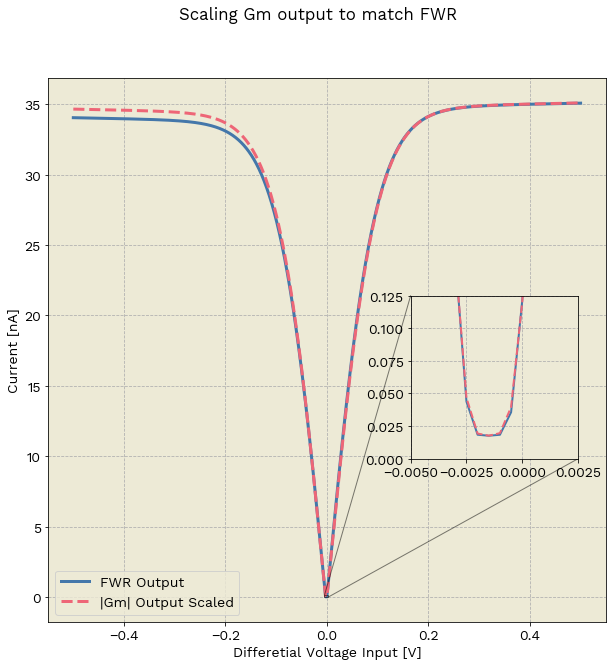

In [55]:
scale_factor =max(df_gm_fw["FWR"])/max(df_gm_fw["Gm"])

offset = min(df_gm_fw["FWR"])*1e9

fig,ax = plt.subplots(1,figsize=[10,10], sharex=True)
fig.suptitle("Scaling Gm output to match FWR")

ax.plot(df_gm_fw["Voltage"], df_gm_fw["FWR"]*1e9, label="FWR Output")
ax.plot(df_gm_fw["Voltage"], (np.abs(df_gm_fw["Gm"])*scale_factor)*1e9+offset, label="|Gm| Output Scaled",linestyle="dashed")

ax.set_ylabel("Current [nA]")
ax.set_xlabel("Differetial Voltage Input [V]")
ax.legend()
axins = ax.inset_axes([0.65, 0.3, 0.3, 0.3])
x1, x2, y1, y2 = -0.005, 0.0025, 0, .125
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels('')
#axins.set_yticklabels('')
axins.plot(df_gm_fw["Voltage"], df_gm_fw["FWR"]*1e9, label="FWR Output", linewidth=2)
axins.plot(df_gm_fw["Voltage"], (np.abs(df_gm_fw["Gm"])*scale_factor)*1e9+offset, label="|Gm| Output",linestyle="dashed", linewidth=2)

ax.indicate_inset_zoom(axins, edgecolor="black")

### Curve Fitting

Now we can try to fit a curve to each of these lines, There are 4 approaches to try:
    
1. Fit a curve to the gm output then scale and add offset like was shown
2. Fit a curve to the FWR output
3. Do a piece wise solution for the FWR output
4. **Use machine a machine learning regression model to fit the curve**

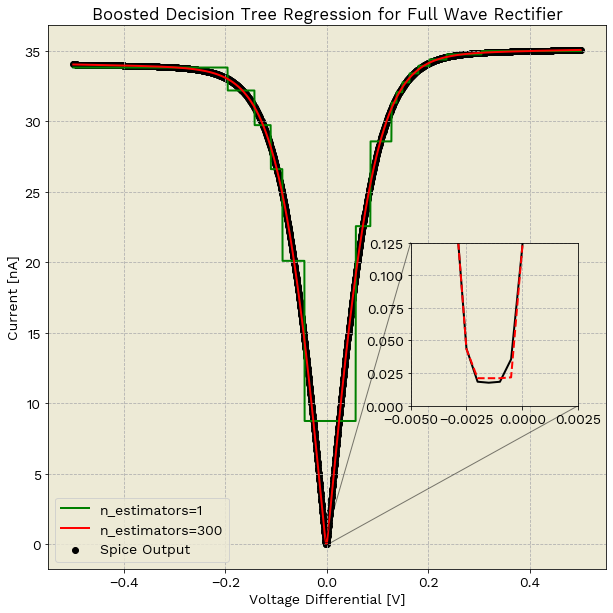

In [57]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

rng = np.random.RandomState(1)
X = np.array(df_gm_fw["Voltage"]).reshape(-1,1)
y = df_gm_fw["FWR"].ravel()*1e9

regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=13),
                          n_estimators=400, random_state=rng)

regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

fix, ax = plt.subplots(figsize=[10,10])
ax.scatter(X, y, c='k', label="Spice Output")
ax.plot(X, y_1, c="g", label="n_estimators=1", linewidth=2)
ax.plot(X, y_2, c="r", label="n_estimators=300", linewidth=2)
ax.set_xlabel("Voltage Differential [V]")
ax.set_ylabel("Current [nA]")
ax.set_title("Boosted Decision Tree Regression for Full Wave Rectifier")
ax.legend()

axins = ax.inset_axes([0.65, 0.3, 0.3, 0.3])
x1, x2, y1, y2 = -0.005, 0.0025, 0, .125
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels('')
#axins.set_yticklabels('')
axins.plot(X, y, c='k', linewidth=2)
axins.plot(X, y_2,c='r', linestyle="dashed", linewidth=2)

ax.indicate_inset_zoom(axins, edgecolor="black")

fig.savefig(img_path+"adaboost_regression_FWR.svg")

This looks like a suitable model for this section of the chip we will use this